## 一，使用 CPU/单GPU 训练你的pytorch模型

当系统存在GPU时，torchkeras 会自动使用GPU训练你的pytorch模型，否则会使用CPU训练模型。

在我们的范例中，单GPU训练的话，一个Epoch大约是18s。

fit
<<<<<< ⚡️ cuda is used >>>>>>


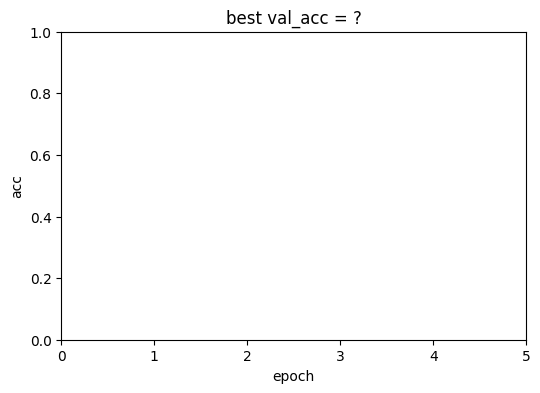

KeyboardInterrupt: 

In [2]:
import torch
from torch import nn 
import torchvision 
from torchvision import transforms
import torchmetrics 
from torchkeras import KerasModel 

### 1，准备数据

def create_dataloaders(batch_size=1024):
    transform = transforms.Compose([transforms.ToTensor()])

    ds_train = torchvision.datasets.MNIST(root="../datasets/mnist/",train=True,download=True,transform=transform)
    ds_val = torchvision.datasets.MNIST(root="../datasets/mnist/",train=False,download=True,transform=transform)

    dl_train =  torch.utils.data.DataLoader(ds_train, batch_size=batch_size, shuffle=True,
                                            num_workers=2,drop_last=True)
    dl_val =  torch.utils.data.DataLoader(ds_val, batch_size=batch_size, shuffle=False, 
                                          num_workers=2,drop_last=True)
    return dl_train,dl_val

dl_train,dl_val = create_dataloaders(batch_size=1024)

### 2，定义模型

def create_net():
    net = nn.Sequential()
    net.add_module("conv1",nn.Conv2d(in_channels=1,out_channels=512,kernel_size = 3))
    net.add_module("pool1",nn.MaxPool2d(kernel_size = 2,stride = 2)) 
    net.add_module("conv2",nn.Conv2d(in_channels=512,out_channels=256,kernel_size = 5))
    net.add_module("pool2",nn.MaxPool2d(kernel_size = 2,stride = 2))
    net.add_module("dropout",nn.Dropout2d(p = 0.1))
    net.add_module("adaptive_pool",nn.AdaptiveMaxPool2d((1,1)))
    net.add_module("flatten",nn.Flatten())
    net.add_module("linear1",nn.Linear(256,128))
    net.add_module("relu",nn.ReLU())
    net.add_module("linear2",nn.Linear(128,10))
    return net 

net = create_net() 


### 3，训练模型

loss_fn = nn.CrossEntropyLoss() 
metrics_dict = {'acc':torchmetrics.Accuracy(task='multiclass',num_classes=10)}

optimizer = torch.optim.AdamW(params=net.parameters(), lr=1e-4)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer=optimizer,T_0=5)

model = KerasModel(net,loss_fn,metrics_dict,optimizer,lr_scheduler)
dfhistory = model.fit(train_data = dl_train,
    val_data = dl_val,
    epochs=5,
    ckpt_path='checkpoint.pt',
    patience=2,
    monitor='val_acc',
    mode='max',
    mixed_precision='no')

### 4，评估模型
model.net.load_state_dict(torch.load('checkpoint.pt'))
print(model.evaluate(dl_val)) 


## 二，使用多GPU DDP模式训练你的pytorch模型

Kaggle中右边settings 中的 ACCELERATOR选择 GPU T4x2。

### 1，设置config 

In [1]:
import os
from accelerate.utils import write_basic_config
write_basic_config() # Write a config file

Configuration already exists at /home/zijieshen/.cache/huggingface/accelerate/default_config.yaml, will not override. Run `accelerate config` manually or pass a different `save_location`.


False

In [ ]:
# or answer some question to create a config
#!accelerate config  

### 2，训练代码

在我们的范例中，双GPU使用DDP模式训练的话，一个Epoch大约是12s。

In [1]:
import torchvision 
from torchvision import transforms
from torch import nn 
import torch
import torchmetrics 
from accelerate import notebook_launcher
from torchkeras.kerasmodel import KerasModel 

### 1，准备数据

def create_dataloaders(batch_size=2):
    transform = transforms.Compose([transforms.ToTensor()])

    ds_train = torchvision.datasets.MNIST(root="./minist/",train=True,download=True,transform=transform)
    ds_val = torchvision.datasets.MNIST(root="./minist/",train=False,download=True,transform=transform)

    dl_train =  torch.utils.data.DataLoader(ds_train, batch_size=batch_size, shuffle=True,
                                            num_workers=2,drop_last=True)
    dl_val =  torch.utils.data.DataLoader(ds_val, batch_size=batch_size, shuffle=False, 
                                          num_workers=2,drop_last=True)
    return dl_train,dl_val

dl_train,dl_val = create_dataloaders(batch_size=1024)

### 2，定义模型

def create_net():
    net = nn.Sequential()
    net.add_module("conv1",nn.Conv2d(in_channels=1,out_channels=512,kernel_size = 3))
    net.add_module("pool1",nn.MaxPool2d(kernel_size = 2,stride = 2)) 
    net.add_module("conv2",nn.Conv2d(in_channels=512,out_channels=256,kernel_size = 5))
    net.add_module("pool2",nn.MaxPool2d(kernel_size = 2,stride = 2))
    net.add_module("dropout",nn.Dropout2d(p = 0.1))
    net.add_module("adaptive_pool",nn.AdaptiveMaxPool2d((1,1)))
    net.add_module("flatten",nn.Flatten())
    net.add_module("linear1",nn.Linear(256,128))
    net.add_module("relu",nn.ReLU())
    net.add_module("linear2",nn.Linear(128,10))
    return net 

net = create_net() 


### 3，训练模型

loss_fn = nn.CrossEntropyLoss() 
metrics_dict = {'acc':torchmetrics.Accuracy(task='multiclass',num_classes=10)}

optimizer = torch.optim.AdamW(params=net.parameters(), lr=1e-4)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer=optimizer,T_0=5)

model = KerasModel(net,loss_fn,metrics_dict,optimizer,lr_scheduler)

ckpt_path = 'checkpoint.pt'
args = dict(train_data = dl_train,
        val_data = dl_val,
        epochs=10,
        ckpt_path= ckpt_path,
        patience=2,
        monitor='val_acc',
        mode='max',
        callbacks=None,
        plot=True,
        wandb=False,
        quiet=None,
        mixed_precision='no'
)

model.fit_ddp(
    num_processes=2,
    **args
)

# ### 4，评估模型
# model.net.load_state_dict(torch.load('checkpoint.pt'))
# print(model.evaluate(dl_val)) 


Launching training on 2 GPUs.
<<<<<< ⚡️ cuda:0 is used >>>>>>
bp 1

================================================================================2024-05-11 18:34:55
Epoch 1 / 10

  0%|                                                                        | 0/29 [00:00<?, ?it/s]